In [39]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision import models
from torchvision import transforms
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
import tensorboard
import seaborn as sns

In [2]:
print(torch.__version__)
print("Is GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

2.6.0+cu124
Is GPU Available: True
GPU Name: NVIDIA A100-SXM4-80GB


In [3]:
# define dataset
class RosetteDataSet(Dataset):
    def __init__(self, image_dir, labels_file, split='train', transform=None, target='n_arms'):
        """
        Args:
            image_dir (string): Directory with subfolders ('train', 'val', 'test') containing images.
            csv_file (string): CSV file containing image filenames and labels.
            split (string): Which data split to use ('train', 'val', 'test').
            transform (callable, optional): Optional transform to be applied on a sample.
            target (string): ['n_arms', 'rho_eff', 'sa_eff']
        """
        self.image_dir = os.path.join(image_dir, split)  # Select the correct subfolder (train/val/test)
        self.labels = pd.read_csv(labels_file)
        self.labels = self.labels[self.labels['split'] == split].reset_index(drop=True)
        self.label_mapping = {
            '4': 0,
            '5': 1,
            '6': 2,
            '7': 3,
            '8': 4,
            '9': 5,
            '10': 6
        }
        self.transform = transform
        self.target = target

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        """Load an image and its corresponding label(s)"""
        row = self.labels.iloc[idx]
        img_name = row['filename']  # Get the image filename
        img_path = os.path.join(self.image_dir, img_name)  # Construct the full image path
        image = Image.open(img_path)
        # Classification label (e.g. n_arms)
        label_str = str(row['n_arms'])  # ensure it's a string
        n_arms_labels = torch.tensor(self.label_mapping[label_str], dtype=torch.long)
        # Regression targets
        regression_targets = torch.tensor([row['rho_eff'], row['sa_eff']], dtype=torch.float32)
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        return image, n_arms_labels, regression_targets

In [4]:
labels_file = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000_default_split/labels.csv'
labels = pd.read_csv(labels_file)
labels.head()

,filename,split,n_arms,rho_eff,sa_eff
0,ros-projection-010913-002-default.png,test,5,0.015800,0.166602
1,ros-projection-016265-058-default.png,test,5,0.057668,0.324473
2,ros-projection-001142-087-default.png,test,4,0.014152,0.147579
3,ros-projection-017988-092-default.png,test,5,0.100758,0.443553
4,ros-projection-057113-091-default.png,test,9,0.026300,0.280913


In [5]:
labels.shape

(7000, 5)

# RosetteDataModule: handles loading/splitting data

In [6]:
class RosetteDataModule(pl.LightningDataModule):
    def __init__(self, image_dir, labels_file, batch_size, target, transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.labels_file = labels_file
        self.batch_size = batch_size
        self.target = target
        self.transform = transform

    def setup(self, stage=None):
        self.train_dataset = RosetteDataSet(self.image_dir, self.labels_file, split='train', transform=self.transform, target=self.target)
        self.val_dataset = RosetteDataSet(self.image_dir, self.labels_file, split='val', transform=self.transform, target=self.target)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

# RosetteModel: LightningModule for one task

In [64]:
class RosetteModel(pl.LightningModule):
    def __init__(self, task='classification', 
                 num_classes=5, 
                 lr=1e-4, 
                 target='rho_eff', 
                 weights=models.ResNet18_Weights.DEFAULT):
        super().__init__()
        self.save_hyperparameters()
        self.task = task
        self.lr = lr
        self.target = target
        # self.backbone = models.resnet18(pretrained=True)
        self.backbone = models.resnet18(weights=weights)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1 if task == 'regression' else num_classes)
        if task == 'classification':
            self.loss_fn = nn.CrossEntropyLoss()
        elif task == 'regression':
            self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, class_label, reg_target = batch
        if self.task == 'classification':
            y_hat = self(x)
            loss = self.loss_fn(y_hat, class_label)
        elif self.task == 'regression':
            y_hat = self(x)
            # Choose target from regression vector
            target_idx = 0 if self.target == "rho_eff" else 1
            y = reg_target[:, target_idx].unsqueeze(1)
            loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, class_label, reg_target = batch
        if self.task == "classification":
            y_hat = self(x)
            loss = self.loss_fn(y_hat, class_label)
            preds = torch.argmax(y_hat, dim=1)
            acc = (preds == class_label).float().mean()
            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)
            # store for confusion matrix
            self.val_preds_list.append(preds.cpu())
            self.val_targets_list.append(class_label.cpu())
            return {"preds": preds.cpu(), "targets": class_label.cpu()}
    
        elif self.task == "regression":
            y_hat = self(x)
            target_idx = 0 if self.target == "rho_eff" else 1
            y = reg_target[:, target_idx].unsqueeze(1)
            loss = self.loss_fn(y_hat, y)
            mae = torch.nn.functional.l1_loss(y_hat, y)  # Optional: add MAE as metric
            self.log("val_loss", loss, prog_bar=True)
            self.log("val_mae", mae, prog_bar=True)    
            self.val_preds_list.append(y_hat.cpu())
            self.val_targets_list.append(y.cpu())
            return {"preds": y_hat.cpu(), "targets": y.cpu()}

    def on_validation_epoch_start(self):
        # Clear lists before each validation epoch
        self.val_preds_list = []
        self.val_targets_list = []

    def on_validation_epoch_end(self):
        # Concatenate results for full epoch
        self.val_preds = torch.cat(self.val_preds_list).numpy()
        self.val_targets = torch.cat(self.val_targets_list).numpy()

    # def test_step(self, batch, batch_idx):
    #     pass

    # def predict_step(self):
    #     pass
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Run training for each task

## a) Predict n_arms (classification)

In [28]:
# setup trainer 
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000_default_split'
num_classes = len(labels['n_arms'].unique())
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = 'resnet-18-n1000-default-n_arms-tb'
csv_log_name = 'resnet-18-n1000-default-n_arms-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dm_class = RosetteDataModule(data_dir, labels_file, batch_size=32, target="n_arms", transform=transform)
model_class = RosetteModel(task='classification', num_classes=num_classes, lr=1e-6)
trainer = Trainer(max_epochs=100, 
                  accelerator="auto",
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=False)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [29]:
# train model
trainer.fit(model_class, dm_class)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-462d23b3-6316-58a3-a82d-26d5032a13c6]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.720    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_datalo

Plot validation results

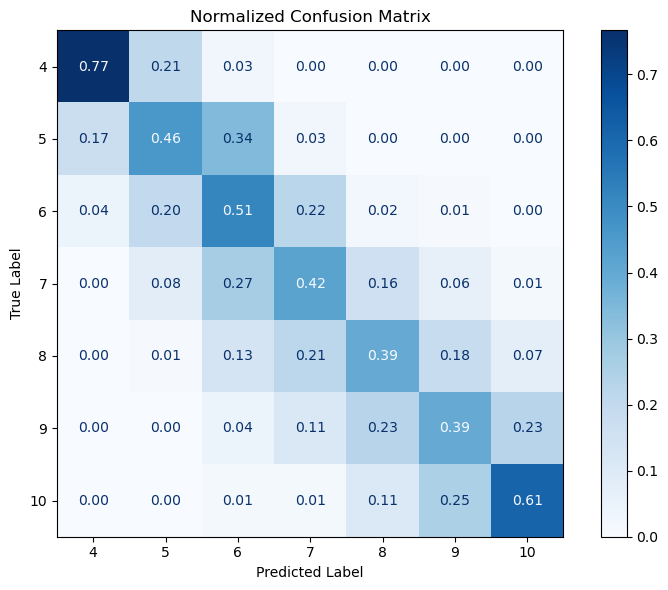

In [30]:
# # run validation
# val_results = trainer.validate(model_class, datamodule=dm_class)
# print(val_results)

# Extract predictions and targets from the model instance
preds = model_class.val_preds
targets = model_class.val_targets
# Compute confusion matrix
cm = confusion_matrix(targets, preds, normalize='true')
# Plot the confusion matrix
class_labels = ['4', '5', '6', '7', '8', '9', '10']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# # Original class labels as strings
# class_labels = ['4', '5', '6', '7', '8', '9', '10']

# # Put model in evaluation mode
# model_class.eval()
# val_loader = dm_class.val_dataloader()

# all_preds = []
# all_targets = []

# with torch.no_grad():
#     for batch in val_loader:
#         x, class_label, _ = batch
#         x = x.to(model_class.device)
#         y_hat = model_class(x)
#         preds = torch.argmax(y_hat, dim=1)

#         all_preds.extend(preds.cpu().numpy())
#         all_targets.extend(class_label.cpu().numpy())

# # Compute the confusion matrix (normalized per row)
# cm = confusion_matrix(all_targets, all_preds, normalize='true')

# # Plot
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# fig, ax = plt.subplots(figsize=(8, 6))
# disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
# plt.title("Normalized Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.tight_layout()
# plt.show()

Index(['epoch', 'step', 'train_loss', 'val_acc', 'val_loss'], dtype='object')


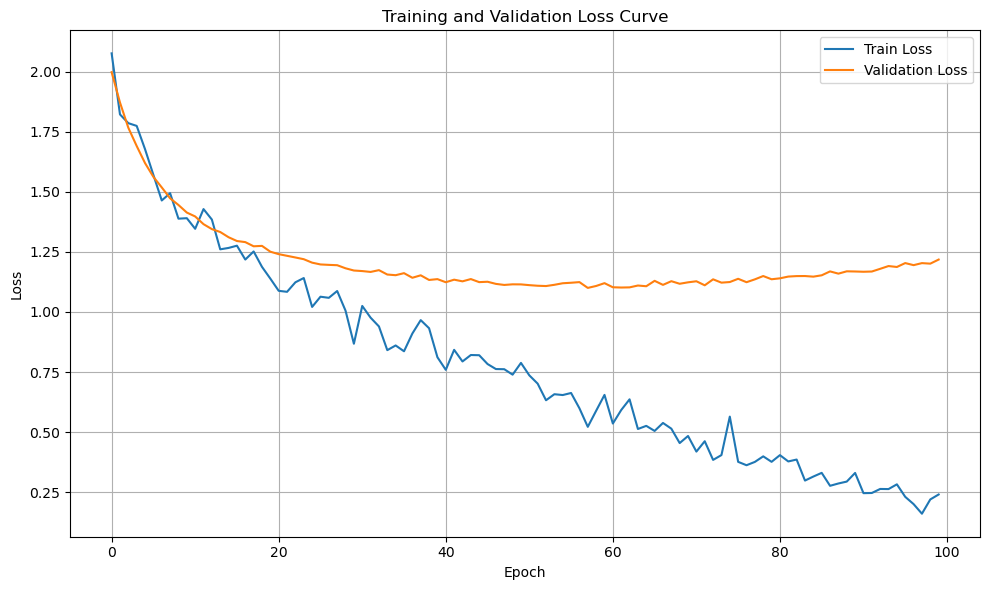

In [31]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/resnet-18-n1000-default-n_arms-csv/version_20/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Drop the 'step' column
metrics_df = metrics_df.drop(columns=['step'])
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
    'val_acc': 'mean'       # Take the mean of the validation accuracy over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')

if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## b) Predict rho_eff (regression)

In [73]:
# setup trainer 
data_dir = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000_default_split'
num_classes = len(labels['n_arms'].unique())
target = 'rho_eff'
log_dir = '/glade/u/home/joko/ice3d/models/lightning_logs'
tb_log_name = f'resnet-18-n1000-default-{target}-tb'
csv_log_name = f'resnet-18-n1000-default-{target}-csv'
tb_logger = TensorBoardLogger(log_dir, name=tb_log_name)
csv_logger = CSVLogger(log_dir, name=csv_log_name)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dm_class = RosetteDataModule(data_dir, labels_file, batch_size=32, target=target, transform=transform)
model_rho = RosetteModel(task='regression', 
                         num_classes=num_classes, 
                         lr=1e-6, 
                         target='rho_eff', 
                         weights=None)
trainer = Trainer(max_epochs=50, 
                  accelerator="auto",
                  logger=[csv_logger, tb_logger],
                  enable_progress_bar=True)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [74]:
# train model
trainer.fit(model_rho, dm_class)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-462d23b3-6316-58a3-a82d-26d5032a13c6]

  | Name     | Type    | Params | Mode 
---------------------------------------------
0 | backbone | ResNet  | 11.2 M | train
1 | loss_fn  | MSELoss | 0      | train
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/glade/u/home/joko/.conda/envs/torch/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 154/154 [00:05<00:00, 27.88it/s, v_num=5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 154/154 [00:05<00:00, 27.73it/s, v_num=5, val_loss=0.00485, val_mae=0.0551]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 154/154 [00:05<00:00, 28.01it/s, v_num=5, val_loss=0.00418, val_mae=0.0513]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 154/154 [00:05<00:00, 27.61it/s, v_num=5, val_loss=0.00365, val_mae=0.048] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 154/154 [00:05<00:00, 27.75it/s, v_num=5, val_loss=0.00327, val_mae=0.0456]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 154/154 [00:05<00:00, 27.72it/s, v_num=5, val_loss=0.00301, val_mae=0.0439]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 154/154 [00:05<00:00, 27.59it/s, v_num=5, val_loss=0.00286, val_mae=0.0427]
Validation: |          | 0/? [00:00<?, ?it/s

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 154/154 [00:06<00:00, 22.27it/s, v_num=5, val_loss=0.00194, val_mae=0.0352]


Index(['epoch', 'step', 'train_loss', 'val_loss', 'val_mae'], dtype='object')


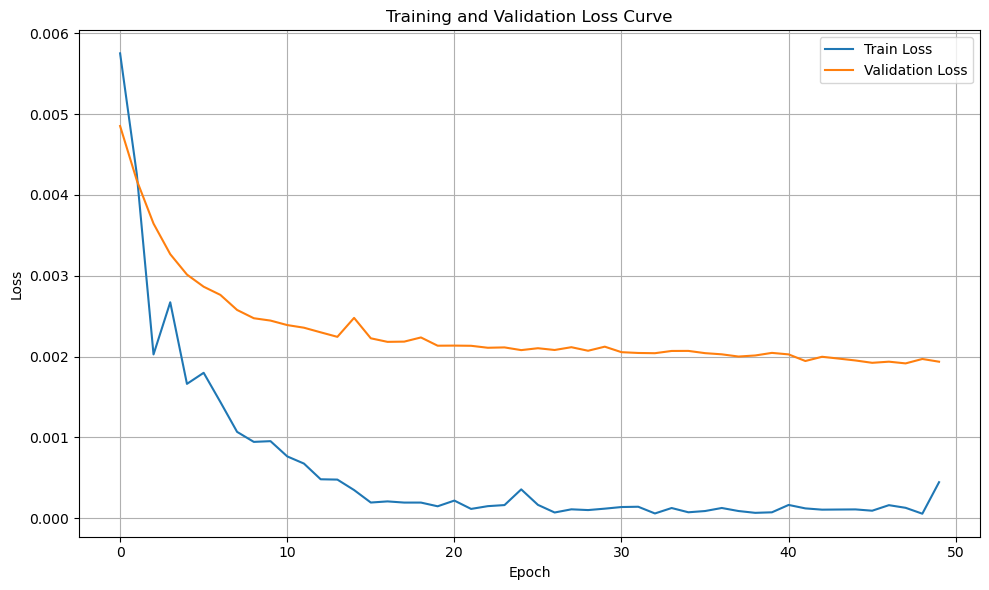

In [75]:
# plot the loss curve
log_path = '/glade/u/home/joko/ice3d/models/lightning_logs/resnet-18-n1000-default-rho_eff-csv/version_5/metrics.csv'
# Read the metrics.csv file using pandas
metrics_df = pd.read_csv(log_path)
# Inspect the columns of the DataFrame (to ensure it's structured properly)
print(metrics_df.columns)
# Drop the 'step' column
metrics_df = metrics_df.drop(columns=['step'])
# Group by 'epoch' and aggregate using the mean (or use 'last' for the final step of each epoch)
metrics_df = metrics_df.groupby('epoch').agg({
    'train_loss': 'mean',   # Take the mean of the training loss over steps in the same epoch
    'val_loss': 'mean',     # Take the mean of the validation loss over steps in the same epoch
    'val_mae': 'mean'       # Take the mean of the validation accuracy over steps in the same epoch
}).reset_index()
# Plot the loss curve (for training and validation losses)
plt.figure(figsize=(10, 6))
# You can plot the training and validation loss curves if both are available in the CSV
if 'train_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')

if 'val_loss' in metrics_df.columns:
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

R2 value for effective density: 0.4119289517402649


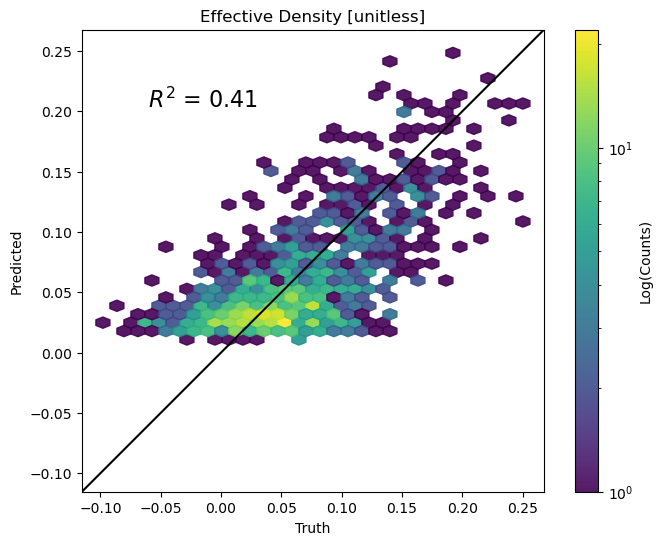

In [76]:
# plot validation scatter plot
# Extract predictions and targets from the model instance
preds = model_rho.val_preds
targets = model_rho.val_targets
# R2 value
r2 = r2_score(preds, targets)
print(f'R2 value for effective density: {r2}')
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
# Create hexbin plot
hb = ax.hexbin(preds, targets, gridsize=30, 
               cmap='viridis', mincnt=1, alpha=0.9, bins='log')
# Add colorbar
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Log(Counts)')
# Plot the identity line (the line where predicted equals truth)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.axline(xy1=(0, 0), slope=1, color='black')
# Set axis limits and labels
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(lims[0], lims[1])
ax.set_aspect('equal')
ax.set_ylabel('Predicted')
ax.set_xlabel('Truth')
ax.set_title('Effective Density [unitless]')
# Add R2 text annotation in relative figure coordinates
ax.text(0.25, 0.75, f'$R^2$ = {r2:.2f}', transform=plt.gcf().transFigure, ha='left', size=16)
# Show the plot
plt.show()

## c) Predict sa_eff (regression)